<a href="https://colab.research.google.com/github/dulaltech101/Recommendation-Systems-Amazon-product-reviews/blob/main/DurgaDulal_RecommendationSystems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project- Recommendation Systems: Amazon product reviews

### **By Durga P. Dulal** 


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The **dataset contains ratings of different electronic products**. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
### Context: 
--------------

Online E-commerce websites like Amazon, Flipkart uses **different recommendation models** to **provide personalized suggestions** to **different users**. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
### Objective:
----------------

Build a recommendation system to **recommend products to customers based on their previous ratings for other products**.

--------------
### Dataset:
--------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

### Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from datetime import datetime

### Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Import the data set
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

In [7]:
# see few rows of the imported dataset
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Exploratory Data Analysis (5 marks)

#### Shape of the data

In [15]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  3


#### Data types

In [16]:
#Check Data types
df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

#### Checking for missing values

In [17]:
# Find number of missing values in each column
(df.isna().sum()/df.shape[0])*100

user_id    0.0
prod_id    0.0
rating     0.0
dtype: float64

#### Summary Statistics

In [18]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

#### Checking the rating distribution

Check the distribution of ratings and **provide observations** from the plot 

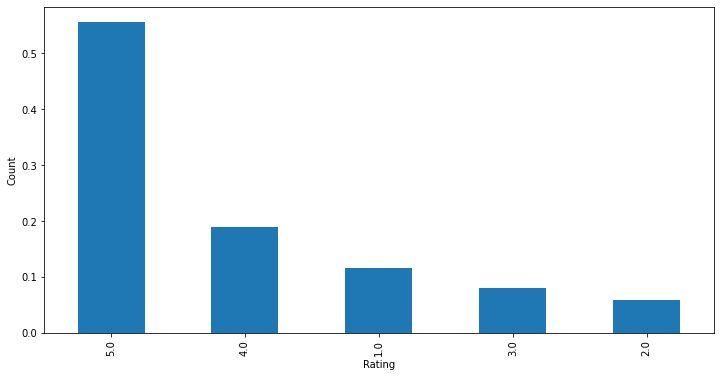

In [19]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

- The most common rating (stars) given to products by users is 5.
- About **78% of ratings are positive with 5 or 4 stars** 
- About 22% of ratings has 3 or below stars

#### Checking the number of unique users and items in the dataset

In [20]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


- There are **42,01,696 users and 4,76,002 products** in the dataset

#### Users with most number of ratings

In [21]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

- The highest number of ratings by a user is 520 which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

### Data preparation  (1 mark)

**Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.**

In [ ]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

#### Checking the density of the rating matrix

In [ ]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Even with the subset of users and products, the current number of ratings is just **0.17%** of the possible number of ratings. This implies that the data is **highly sparse**.
- We will build recommendation systems to recommend products to users with which they have not interacted.

Now that we have explored and preprocessed the data, let's build the first recommendation system

### Rank Based Recommendation System (10 marks)

In [ ]:
#Calculate the average rating for each product 
average_rating = df_final.groupby('prod_id').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Avg Rating': average_rating, 'Rating count': count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating
final_rating.sort_values(by='Rating count', ascending=False, inplace=True)

final_rating.head()

,Avg Rating,Rating count
prod_id,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


In [ ]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding movies with minimum number of interactions
    recommendations = final_rating[final_rating['Rating count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations.sort_values(by='Avg Rating', ascending=False, inplace=True)
    
    return recommendations.index[:n]


#### Recommending top 5 products with 50 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### Recommending top 5 products with 100 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the top 5 products by using popularity recommendation system. Now, let's build a recommendation system using collaborative filtering

### Collaborative Filtering based Recommendation System (15 marks)

In [ ]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format**

In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's define a **function to get similar users** for a particular user

In [ ]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]):
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([final_ratings_matrix.loc[user_index]], [final_ratings_matrix.iloc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user, sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [ ]:
similar = similar_users(3, final_ratings_matrix)[0][0:10]
similar

[3, 320, 12, 793, 261, 156, 1493, 1250, 567, 753]

In [ ]:
#Print the similarity score
similar_users(3, final_ratings_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [ ]:
similar = similar_users(1521, final_ratings_matrix)[0][0:10]
similar

[1521, 991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785]

In [ ]:
#Print the similarity score
similar_users(1521, final_ratings_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

We have found similar users for a given user. Now, let's create **a function to recommend products** to the user using the ratings given by similar users.

In [ ]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [ ]:
recommendations(3, 5, final_ratings_matrix)

['B00114LG7U', 'B001GCQ3KM', 'B000067SF5', 'B0002L5R78', 'B0054U6CEE']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [ ]:
recommendations(1521, 5, final_ratings_matrix)

['B00DQZQG3G', 'B0079TOEQQ', 'B0035JJJQE', 'B00CF5OHZ2', 'B004T9RR6I']

We have applied two technique to recommend products to users. Now, let's build one more recommendation system using matrix factorization (SVD).

### Model based Collaborative Filtering: Singular Value Decomposition  (15 marks)

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

In [ ]:
from scipy.sparse.linalg import svds # for sparse matrices

# Singular Value Decomposition
U, s, Vt = svds(final_ratings_matrix, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [ ]:
U.shape #checking the shape of the U matrix

(1540, 50)

In [ ]:
sigma.shape #checking the shape of the sigma matrix

(50, 50)

In [ ]:
Vt.shape #checking the shape of the Vt matrix

(50, 48190)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma),Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,0.002952,0.008525,0.001923,0.000429,0.002886,0.003949,0.020008,0.003876,0.008363,0.056064,0.006805,0.004928,0.004677,0.003610,0.030306,0.000370,0.016971,0.000269,0.020698,0.002063,0.000333,0.011196,0.000988,0.003445,0.003703,0.004937,0.009938,0.001626,0.002329,0.005118,...,0.062713,0.004551,0.020934,0.026889,0.000050,0.080949,0.305623,0.023159,0.051055,0.001275,0.306615,0.032136,0.003623,0.033317,0.211126,0.021486,0.000569,0.012997,0.186545,0.080949,0.112158,0.028931,0.007026,0.379500,0.158210,0.201766,0.089726,0.206036,0.013959,0.063592,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,0.023243,0.004748,0.007898,0.000623,0.005389,0.003116,0.013192,0.008088,0.010724,0.003728,0.008536,0.008795,0.002515,0.017664,0.000958,0.000209,0.004533,0.001912,0.014662,0.015882,0.003647,0.003395,0.001423,0.001034,0.001213,0.000066,0.007949,0.000794,0.030156,0.008864,...,0.028062,0.069751,0.100250,0.051989,0.000351,0.038586,0.018456,0.012207,0.090763,0.011983,0.000578,0.004127,0.034131,0.065956,0.109507,0.022539,0.000627,0.038570,0.088151,0.038586,0.045624,0.023247,0.008727,0.021204,0.017318,0.015402,0.036499,0.180672,0.027860,0.059609,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,0.003830,0.000115,0.052219,0.000099,0.001889,0.001633,0.009597,0.002312,0.013302,0.030823,0.004591,0.005223,0.005087,0.047911,0.011540,0.000369,0.005437,0.001589,0.016260,0.003775,0.001121,0.002047,0.000017,0.001266,0.001747,0.000410,0.006464,0.000288,0.002617,0.004736,...,0.034186,0.018237,0.006772,0.073118,0.000089,0.043818,0.033330,0.011557,0.075729,0.007235,0.008621,0.112510,0.011972,0.058533,0.043062,0.012472,0.000213,0.005964,0.107058,0.043818,0.032366,0.072784,0.029582,0.125087,0.003514,0.015004,0.025893,0.178518,0.020809,0.008984,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,0.004506,0.005046,0.005222,0.009216,0.002443,0.003019,0.012704,0.007380,0.002409,0.007586,0.008402,0.004391,0.006039,0.033126,0.001186,0.000356,0.010548,0.000258,0.031719,0.000704,0.000331,0.009481,0.000550,0.001440,0.001920,0.000710,0.001126,0.000525,0.001888,0.007548,...,0.032608,0.025964,0.026600,0.038492,0.000487,0.010766,0.020472,0.002667,0.052217,0.003392,0.033634,0.036008,0.004066,0.014100,0.084241,0.015887,0.000318,0.025996,0.041410,0.010766,0.032706,0.033007,0.007304,0.122311,0.041287,0.125360,0.026164,0.126303,0.000990,0.003605,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,0.019896,0.006029,0.048403,0.002085,0.000791,0.002448,0.013900,0.002457,0.003344,0.016090,0.007060,0.000141,0.00

We have the prediction of ratings but we need to create a **function to recommend products** to the users on the basis of predicted ratings for each product

In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(user_index, interactions_matrix, preds_df, num_recommendations):
    
    # Get and sort the user's ratings from the actual and predicted interaction matrix
    sorted_user_ratings = interactions_matrix.loc[user_index].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[user_index].sort_values(ascending=False)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Products'
    temp.columns = ['user_ratings', 'user_predictions']
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions', ascending=False) #Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

**Recommending top 5 products to user id 121**

In [ ]:
#Enter 'user index' and 'num_recommendations' for the user
user_index = 121
num_recommendations = 5
recommend_items(user_index, final_ratings_matrix, preds_df, num_recommendations)


Below are the recommended products for user(user_id = 121):

Recommended Products
B004CLYEDC    2.414390
B0088CJT4U    1.521306
B009NHWVIA    1.309224
B008ULPAT2    1.200111
B005I6EU48    1.126866
Name: user_predictions, dtype: float64


**Recommending the 5 products to user index 465**

In [ ]:
#Enter 'user_index' and 'num_recommendations' for the user #
user_index = 465
num_recommendations = 5
recommend_items(user_index, final_ratings_matrix, preds_df, num_recommendations)


Below are the recommended products for user(user_id = 465):

Recommended Products
B008DWCRQW    1.038076
B0079UAT0A    0.809093
B008X9ZBVI    0.801342
B00829TIA4    0.747477
B008X9Z528    0.702148
Name: user_predictions, dtype: float64


### Evaluate the model (10 marks)

#### Evaluation of the Model based Collaborative Filtering (SVD)

In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

NameError: ignored

In [ ]:
# Find average actual rating for each item
final_ratings_matrix.mean()

In [ ]:
# Predicted ratings 
preds_df.head()

In [ ]:
# Find average predicted rating for each item
preds_df.mean()

In [ ]:
#create a dataframe containing average actual ratings and avearge predicted ratings for each product
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

In [ ]:
#Calculate and print RMSE using the mean_square_error function
RMSE = np.sqrt((sum((rmse_df['Avg_actual_ratings']-rmse_df['Avg_predicted_ratings'])**2))/rmse_df.shape[0] )
print('\nRMSE SVD Model = {} \n'.format(RMSE))

### Recommendation (2 marks)

#### Recommend top 10 products to the user id 100

In [ ]:
# Enter 'user_index' and 'num_recommendations' for the user #
user_index = 100
num_recommendations = 10 
recommend_items(user_index, final_ratings_matrix, preds_df, num_recommendations)


Below are the recommended products for user(user_id = 100):

Recommended Products
B000N99BBC    1.624746
B001CHHVCU    1.132730
B000JMJWV2    1.047888
B002SZEOLG    0.955049
B001TH7GSW    0.879705
B009SYZ8OC    0.854430
B00DIFIM36    0.816153
B00BGGDVOO    0.803755
B004CLYEDC    0.748799
B0015DYMVO    0.748797
Name: user_predictions, dtype: float64


### Conclusion (2 marks)

**Conclusion:**

In this project, Durga's recommend **personlized products** to the different customers using following recommendation models   

**Rank Based** Recommendation System (Popularity based)
  - Recommended products/items based on popularity/trend. 
  - Algorithm look for products/movies that are currently trending/most popularity 

**Collaborative Filtering based** Recommendation System
-   Based on similar users that is calcualted using *cosine similarity* and recommend products rated by the similar users.

**Model based Collaborative Filtering: Singular Value Decomposition {(matrix factorization (SVD)}**
 - Sparsity & scalability are the two biggest problems with the collaborative filtering method. So we use the singular value decomposition, which is the matrix-factorization technique. It reduces the original sparse matrix to low-dimensional matrices with latent features & less sparsity. And 
tells us how much a user agrees with a set of latent features and how much a movie/product fits into that set of latent features. 
 - Its also known as personalized recommendation system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

Hence, we **learned the merits and drawbacks** of these recommendation systems and when to use which type of recommendation system.
